**Кластеризация текстов при помощи W2V и BERT эмбеддингов**

In [1]:
import umap # Импортирую umap в начале т.к. в некоторых случаях приводит к бесконечной загрузке :(

Загрузка и предобработка текста

In [2]:
from sklearn.datasets import fetch_20newsgroups #

In [3]:
random_state = 1337

In [4]:
categories = ['sci.crypt',
              'sci.electronics',
              'sci.med',
              'sci.space']
text = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=random_state).data

In [5]:
len(text)

2373

In [6]:
import re
import nltk
nltk.download('stopwords')

def pre_process(str):
    str = str.lower()
    str = re.sub(r'[^\w\s]','',str) # Удаление знаков препинания
    tokens = nltk.word_tokenize(str)
    stop_words = nltk.corpus.stopwords.words('english')
    tokens = [w for w in tokens if not w in stop_words and len(w) > 2]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\St0negor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
processed_text = []
for doc in text:
    processed_text.append(pre_process(doc))

In [8]:
len(processed_text)

2373

Загрузим предобученные w2v и закодируем текст

In [9]:
import gensim.downloader as api
wiki_model = api.load("glove-wiki-gigaword-100")
twitter_model = api.load("glove-twitter-25")

In [10]:
import numpy as np
from tqdm.autonotebook import tqdm
def encode(text, wv):
    vectors = []
    vocab = set(wv.index_to_key)
    for doc in tqdm(text):
        doc_vec = []
        for word in doc.split():
            if word not in vocab:
                continue
            doc_vec.append(wv[word])
        doc_embedded = np.average(doc_vec, axis=0)
        vectors.append(doc_embedded)
    return np.array(vectors)

In [11]:
wiki_features = encode(processed_text, wiki_model)
twitter_features = encode(processed_text, twitter_model)

wiki_features.shape

  0%|          | 0/2373 [00:00<?, ?it/s]

  0%|          | 0/2373 [00:00<?, ?it/s]

(2373, 100)

Загрузим предобученные модели BERT и получим вектора документов

In [12]:
from sentence_transformers import SentenceTransformer # Простой способ получить sentence embeddings из BERT

model = SentenceTransformer('all-distilroberta-v1') # https://huggingface.co/distilroberta-base
MiniLM_features = model.encode(processed_text)

model = SentenceTransformer('all-MiniLM-L6-v2') # https://huggingface.co/nreimers/MiniLM-L6-H384-uncased
distilroberta_features = model.encode(processed_text)

In [13]:
embeddings = [wiki_features, twitter_features, MiniLM_features, distilroberta_features]
titles = ['W2V Wiki', 'W2V Twitter', 'BERT MiniLM', 'DistilRoBERTa']

Для начала посмотрим на реальное расположение тематик

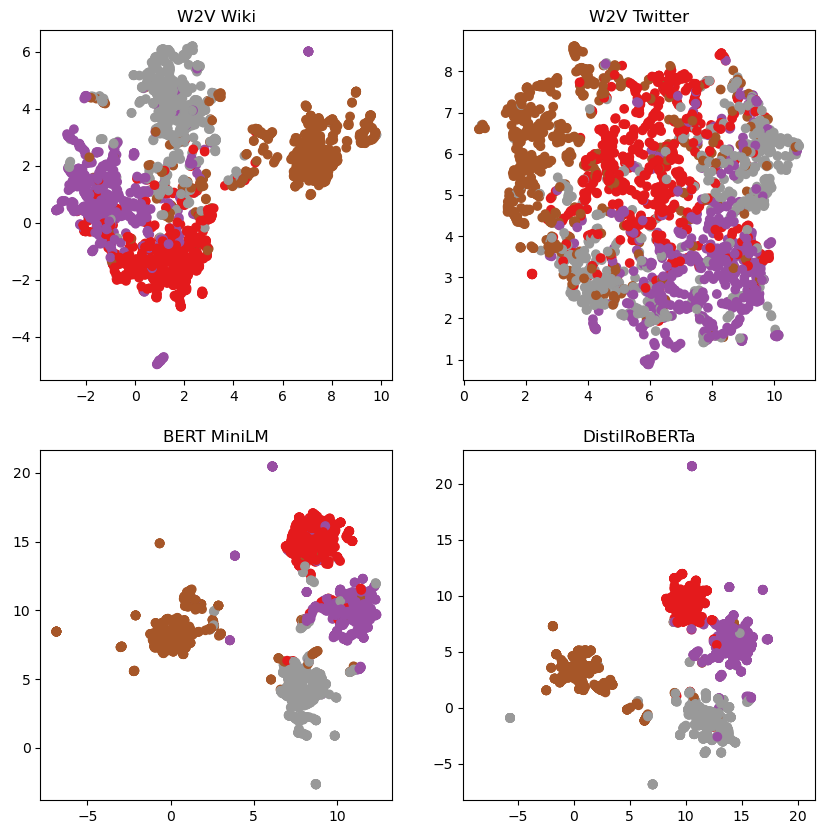

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.ravel()
labels = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=random_state).target
for i, embedding in enumerate(embeddings):
    reduced_data = umap.UMAP(n_components=2,metric='cosine',n_neighbors=5, min_dist=0.005 ,random_state=random_state).fit_transform(embedding)
    axs[i].scatter(
        reduced_data[:, 0],
        reduced_data[:, 1],
        c = labels,
        cmap = 'Set1')
    axs[i].title.set_text(titles[i])
plt.gca().set_aspect('equal', 'datalim')
plt.show()


Определим функцию визуализации кластеров

In [15]:
def plot_clusters(predictions):
    fig, axs = plt.subplots(4,2, figsize=(10,20))
    axs = axs.ravel()
    labels = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=random_state).target
    for i, embedding in enumerate(embeddings):
        reduced_data = umap.UMAP(n_components=2,metric='cosine',n_neighbors=5, min_dist=0.01 ,random_state=random_state).fit_transform(embedding)

        axs[i*2].scatter(
            reduced_data[:, 0],
            reduced_data[:, 1],
            c = predictions[i],
            cmap = 'Set1')
        axs[i*2].title.set_text(titles[i] + " predictions")

        axs[i*2+1].scatter(
            reduced_data[:, 0],
            reduced_data[:, 1],
            c = labels,
            cmap = 'Set2')  # Using a different color scheme for ground truth, so it is clear that color shouldn't match
        axs[i*2+1].title.set_text(titles[i] + " ground truth")
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()

Несложно заметить, что разделение на кластеры наиболее выражено для BERT представлений документов

Найдем количество кластеров при помощи elbow method

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:965: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'full' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


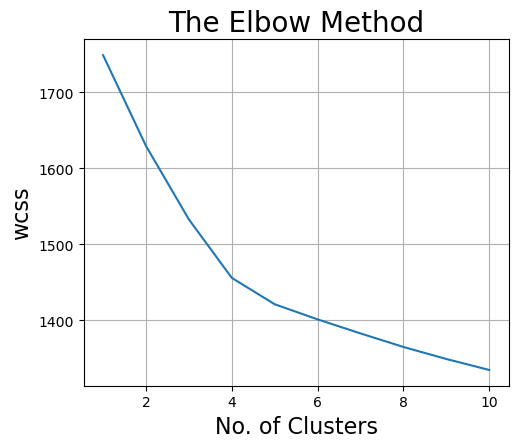

In [16]:
from sklearn.cluster import  KMeans
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0,
                algorithm = 'elkan',
                tol = 0.001)

    km.fit(MiniLM_features)
    labels = km.labels_
    wcss.append(km.inertia_)

plt.rcParams['figure.figsize'] = (5, 4)
plt.plot(range(1, 11), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters', fontsize = 16)
plt.ylabel('wcss', fontsize = 16)
plt.show()

Ожидаемо, наибольшая точка изгиба наблюдается для количества кластеров равного четырем. (т.к. импортировали 4 темы)

In [17]:
from sklearn.cluster import KMeans

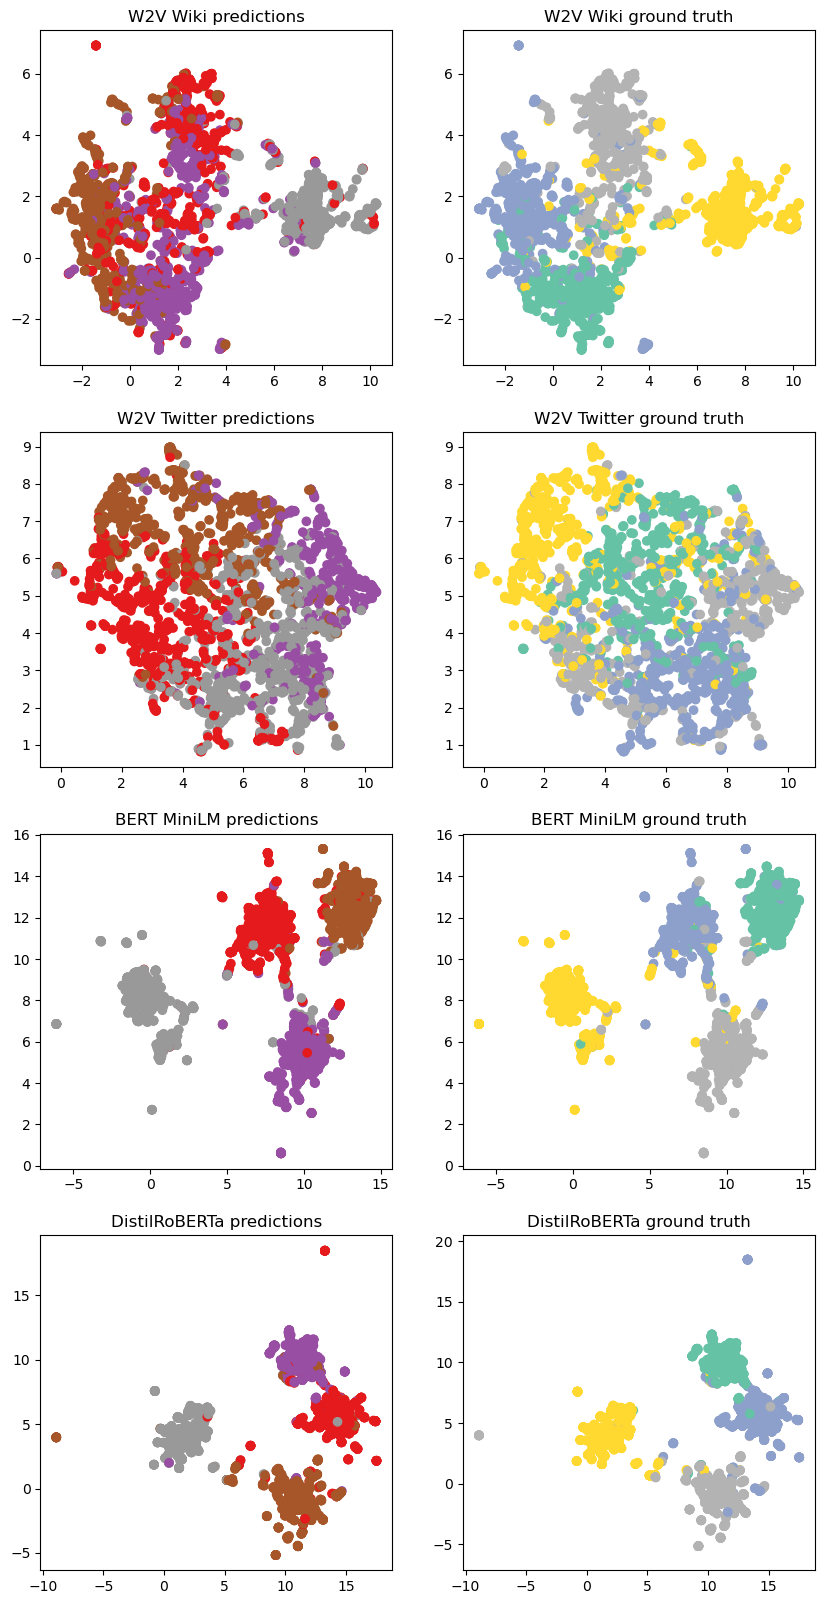

In [18]:
kmeans_predictions = []
for embedding in embeddings:
    prediction = KMeans(n_clusters=4, random_state=random_state).fit(embedding)
    kmeans_predictions.append(prediction.labels_)
plot_clusters(kmeans_predictions)

KMeans справляется с задачей кластеризации на BERT представлениях, однако неправильно определил кластеры для w2v представлений.

In [19]:
from sklearn.cluster import SpectralClustering

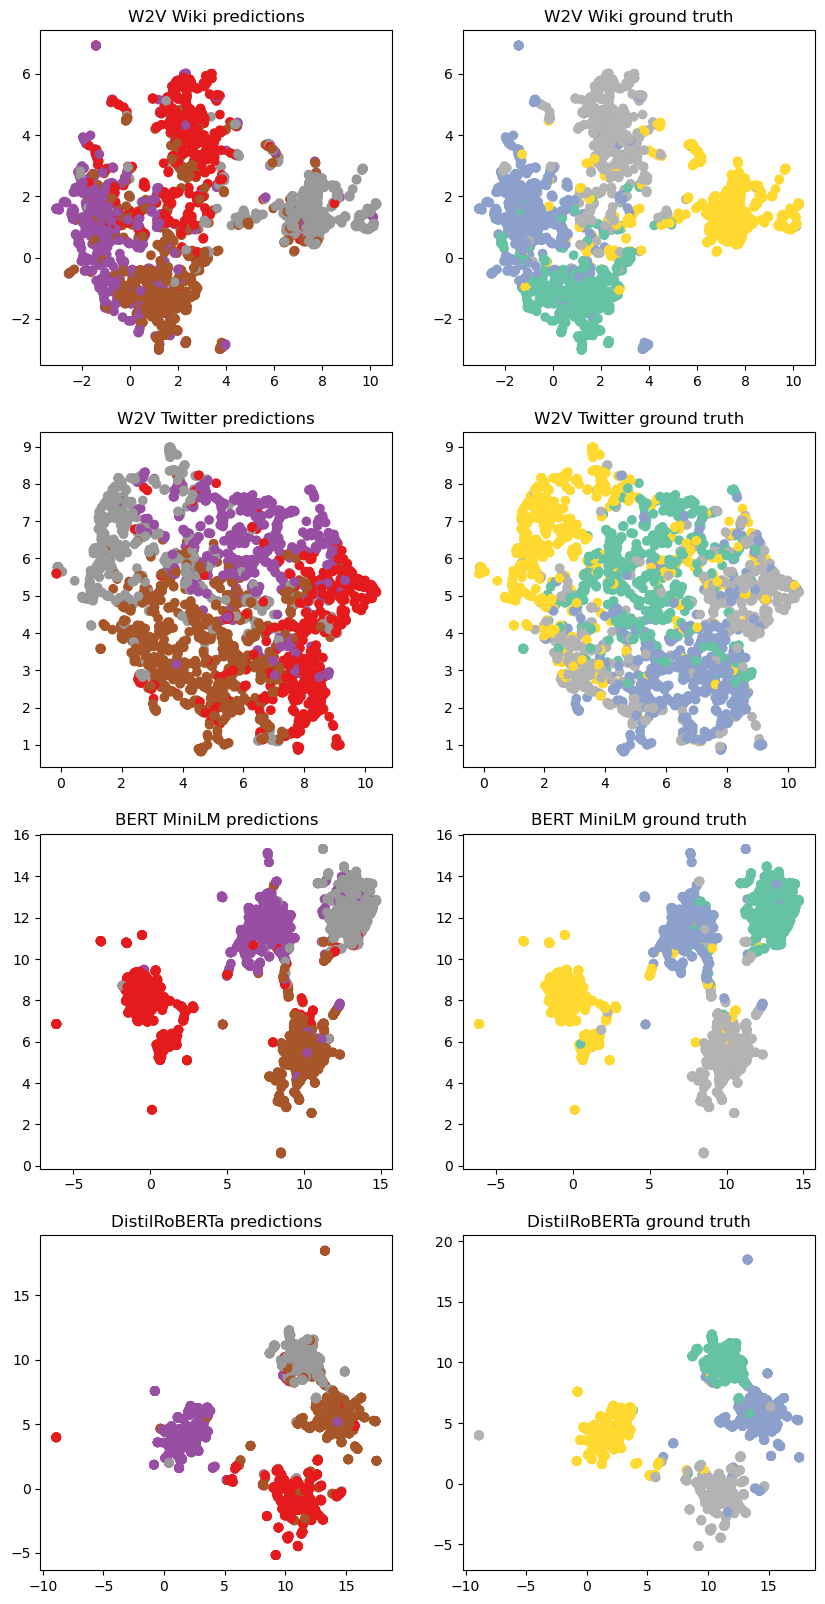

In [20]:
spectral_predictions = []
for embedding in embeddings:
    prediction = SpectralClustering(n_clusters=4).fit(embedding)
    spectral_predictions.append(prediction.labels_)
plot_clusters(spectral_predictions)

Спектральная Кластеризация справилась со всеми представлениями, кроме twitter-w2v.

Попробуем настроить DBSCAN для кластеризации документов

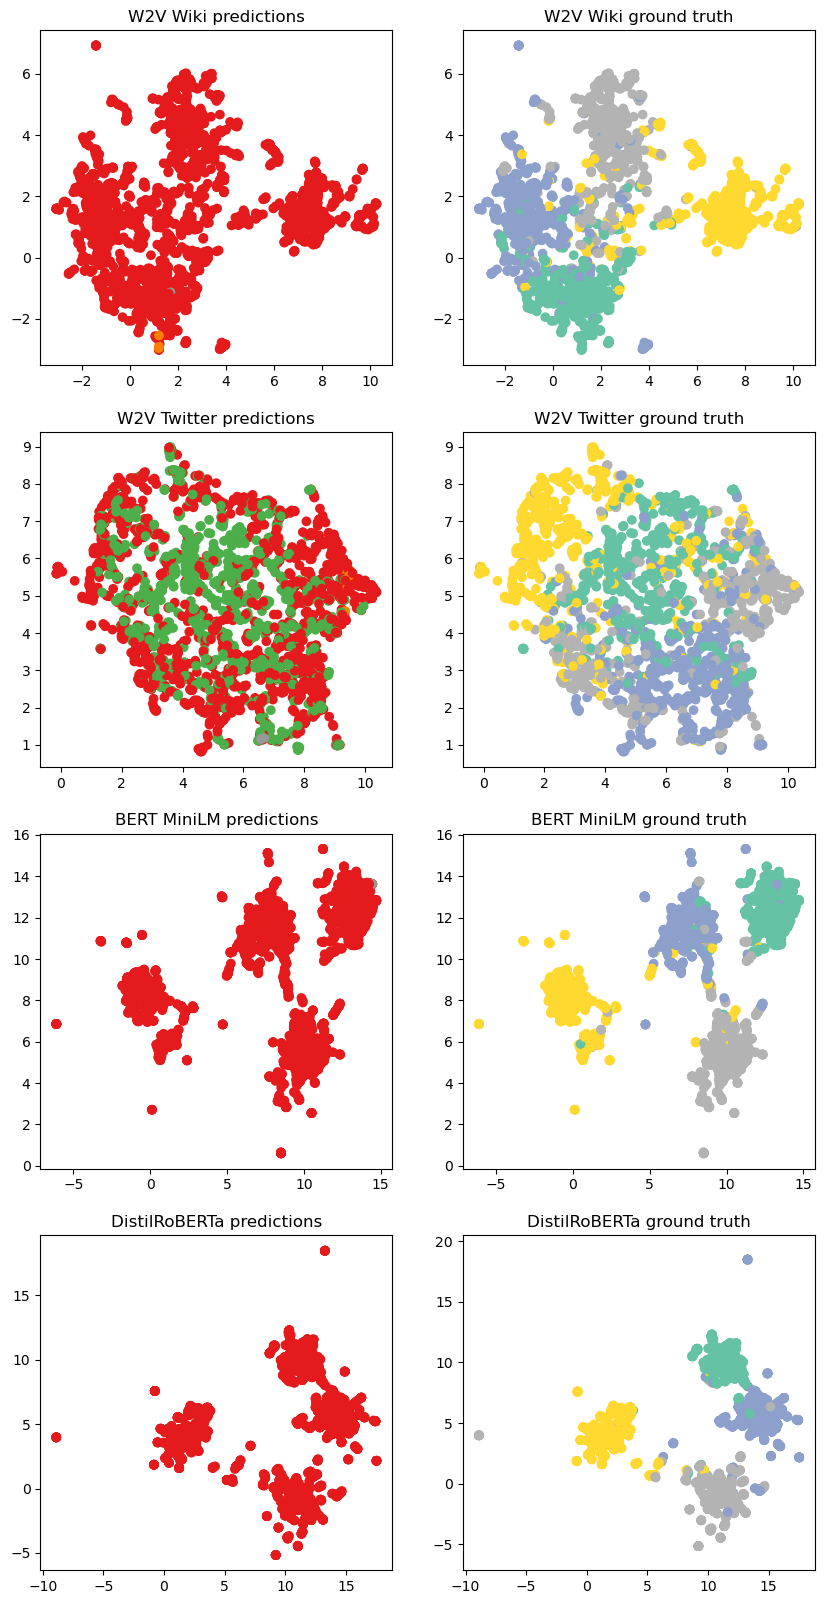

In [21]:
from sklearn.cluster import DBSCAN
DBSCAN_predictions = []
for embedding in embeddings:
    prediction = DBSCAN(eps=0.4).fit(embedding)
    DBSCAN_predictions.append(prediction.labels_)
plot_clusters(DBSCAN_predictions)

In [22]:
'''

# Plots a bunch of graphs for different values of epsilon, none of them turned out to be useful

from sklearn.cluster import DBSCAN
for eps in [0.3,0.35,0.4,0.45,0.5, 0.01, 0.1, 10]:
  predictions = []
    for embedding in embeddings:
        prediction = DBSCAN(eps=eps).fit(embedding)
        predictions.append(prediction.labels_)
    plot_clusters(predictions)
'''

'\n\n# Plots a bunch of graphs for different values of epsilon, none of them turned out to be useful\n\nfrom sklearn.cluster import DBSCAN\nfor eps in [0.3,0.35,0.4,0.45,0.5, 0.01, 0.1, 10]:\n  predictions = []\n    for embedding in embeddings:\n        prediction = DBSCAN(eps=eps).fit(embedding)\n        predictions.append(prediction.labels_)\n    plot_clusters(predictions)\n'

Очевидно нужен более [разумный подход](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc) к нахождению значения эпсилон

Способ напоминает elbow method, но для определения eps

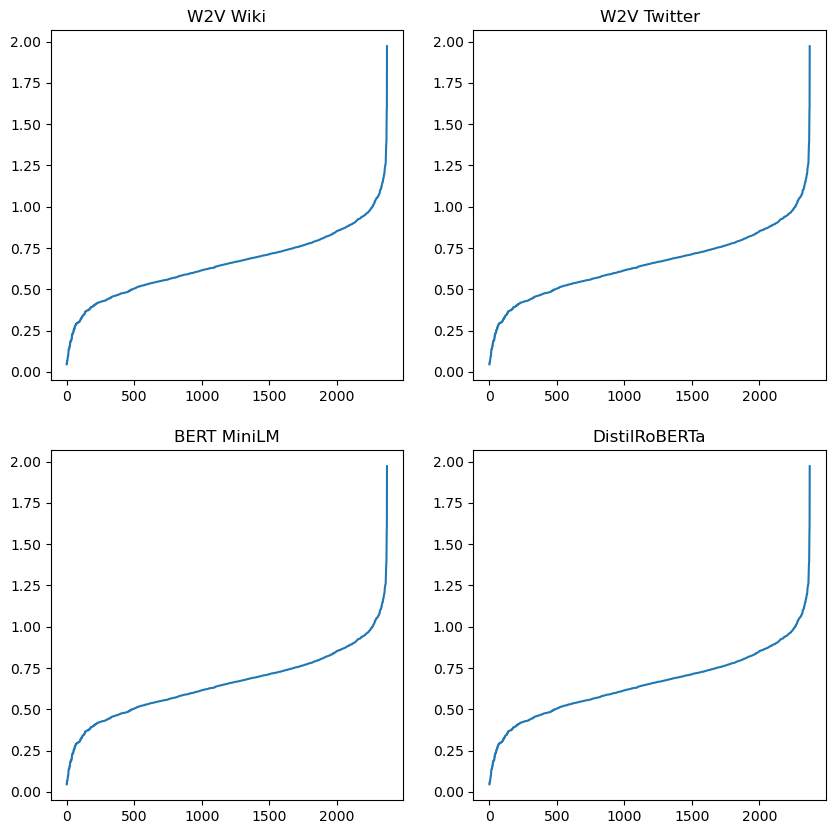

In [23]:
from sklearn.neighbors import NearestNeighbors
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.ravel()
for i, embedding in enumerate(embeddings):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(wiki_features)
    distances, indices = nbrs.kneighbors(wiki_features)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    axs[i].plot(distances)
    axs[i].title.set_text(titles[i])
plt.show()

Для каждого эмбеддинга максимальный перегиб происходит примерно на eps = 0.9 и 0.4, исследуем эти значения

In [24]:
'''  # Ещё больше бесполезных графиков

for eps in [0.38,0.4,0.42]:
    predictions = []
    for embedding in embeddings:
        prediction = DBSCAN(eps=eps).fit(embedding)
        predictions.append(prediction.labels_)
    plot_clusters(predictions)

for eps in [0.85,0.9,0.95]:
    predictions = []
    for embedding in embeddings:
        prediction = DBSCAN(eps=eps).fit(embedding)
        predictions.append(prediction.labels_)
    plot_clusters(predictions)
'''

'  # Ещё больше бесполезных графиков\n\nfor eps in [0.38,0.4,0.42]:\n    predictions = []\n    for embedding in embeddings:\n        prediction = DBSCAN(eps=eps).fit(embedding)\n        predictions.append(prediction.labels_)\n    plot_clusters(predictions)\n\nfor eps in [0.38,0.4,0.42]:\n    predictions = []\n    for embedding in embeddings:\n        prediction = DBSCAN(eps=eps).fit(embedding)\n        predictions.append(prediction.labels_)\n    plot_clusters(predictions)\n'

Ни одно из исследуемых значений не привело к удовлетворительному результату.

Сравним метрики для K-Means и Spectral embeddings

In [25]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import  davies_bouldin_score
from prettytable import PrettyTable
from sklearn.metrics import mutual_info_score
t = PrettyTable(['Clustering', 'DBI', 'Silhouette', 'Mutual Information'])
alg = ["K-Means ", "Spectral "]
t.align['Clustering'] = 'l'
for i, predictions in enumerate([kmeans_predictions, spectral_predictions]):
    for j,prediction in enumerate(predictions):
        # Compute DBI score
        dbi = davies_bouldin_score(embeddings[j], prediction)

        # Compute Silhoutte Score (closer to 1 is better)
        ss = silhouette_score(embeddings[j], prediction, metric='euclidean')

        mi = mutual_info_score(labels,prediction) # Внешняя метрика !!!
        # Print the DBI and Silhoutte Scores (smaller is better)
        #print("DBI Score for " + p + ": ", dbi, "\nSilhoutte Score for " + p + ": ", ss)
        t.add_row([alg[i] + titles[j], dbi, ss, mi])

print(t)

+------------------------+--------------------+-------------+---------------------+
| Clustering             |        DBI         |  Silhouette |  Mutual Information |
+------------------------+--------------------+-------------+---------------------+
| K-Means W2V Wiki       | 2.7916888202440586 | 0.075160645 |  0.4779082995723339 |
| K-Means W2V Twitter    | 2.2229381145762224 |  0.10106577 | 0.17512841370537197 |
| K-Means BERT MiniLM    | 2.994789900653186  |  0.09069272 |   1.11821344943855  |
| K-Means DistilRoBERTa  | 3.7057199185895477 |  0.06159921 |  1.0451130644116995 |
| Spectral W2V Wiki      | 2.8086429547740273 | 0.072687745 |  0.5330598983274476 |
| Spectral W2V Twitter   | 2.2879677959887537 |  0.09606651 |  0.2416861282225807 |
| Spectral BERT MiniLM   | 3.0005389502441058 |  0.0889171  |  1.098100888087157  |
| Spectral DistilRoBERTa | 3.7224834126709543 | 0.059164762 |  0.9838520338409852 |
+------------------------+--------------------+-------------+---------------

Выводы:
1) Если простой алгоритм кластеризации сработал быстро и эффективно, не стоит тратить время на оптимизацию сложного.
2) Алгоритмы кластеризации лучше работают на BERT представлениях документов, чем на усредненных значениях w2v.